In [1]:
import torch
import umap
import anndata
import numpy as np
import os
import gc
import pandas as pd
import timeit
import warnings
warnings.filterwarnings('ignore')
import faiss
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import sklearn
from scipy import stats
import scanpy as sc
from numpy import linalg as LA
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine as cos
import anndata
from matplotlib.pyplot import figure
from multiprocessing import Process

from fast_generator_covid import *
from fast_functions_covid import *

Global seed set to 0


scVI ready


/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
1+1

2

In [3]:
BATCH_SIZE = 4
pids=[]
f = open('sids.txt','r')
lines=f.readlines()
for l in lines:
    pids.append(l.strip())

In [4]:
len(pids)

124

In [5]:
reprefile = 'training_rec/init_representatives_4.txt' 
clusterfile = 'training_rec/init_cluster_labels_4.txt' 



f= open(reprefile,'r')
lines=f.readlines()
init_representatives=[]
for l in lines:
    init_representatives.append(int(l.strip().split()[0]))
f.close()

f= open(clusterfile,'r')
init_cluster_labels=[]
lines=f.readlines()
for l in lines:
    init_cluster_labels.append(int(l.strip().split()[0]))
f.close()

In [6]:
init_representatives

[86, 42, 70, 106]

In [7]:
### evaluation functions

def faiss_knn(query, x, n_neighbors=1):
    n_samples = x.shape[0]
    n_features = x.shape[1]
    x = np.ascontiguousarray(x)
    
    index = faiss.IndexFlatL2(n_features)
    #index = faiss.IndexFlatIP(n_features)
                  
    index.add(x)
    
    if n_neighbors < 2:
        neighbors = 2
    else: 
        neighbors = n_neighbors
    
    weights, targets = index.search(query, neighbors)

    #sources = np.repeat(np.arange(n_samples), neighbors)
    #targets = targets.flatten()
    #weights = weights.flatten()
    weights = weights[:,:n_neighbors]
    if -1 in targets:
        raise InternalError("Not enough neighbors were found. Please consider "
                            "reducing the number of neighbors.")
    return weights

def pearson_compare(query,x):
    return 0

def cos_compare(query,x):
    return 0


def pca_compare(query,x):
    qx = np.concatenate([query,x],axis=0)
    qxpca = PCA(n_components=100)
    dx=qxpca.fit_transform(qx)
    
    newq = dx[:query.shape[0],:].copy(order='C')
    newx = dx[query.shape[0]:,:].copy(order='C')
    score = faiss_knn(newq,newx,n_neighbors=1)
    return score

def umap_compare(query,x):
    qx = np.concatenate([query,x],axis=0)
    qxpca = PCA(n_components=100)
    dpca=qxpca.fit_transform(qx)
    umap_reduc=umap.UMAP(min_dist=0.5,spread=1.0,negative_sample_rate=5 )
    dx = umap_reduc.fit_transform(dpca)
    newq = dx[:query.shape[0],:].copy(order='C')
    newx = dx[query.shape[0]:,:].copy(order='C')
    score = faiss_knn(newq,newx,n_neighbors=1)
    return score

def knncompare(query,x,n_neighbors=1,dist='PCA'):
    if dist == 'Euclidean':
        score = faiss_knn(query,x,n_neighbors=n_neighbors)
        score2 = faiss_knn(x,query,n_neighbors=n_neighbors)
    elif dist == 'Pearson':
        score = pearson_compare(query,x)
        score2 = pearson_compare(x,query)
    elif dist == 'cos':
        score = cos_compare(query,x)
        score2 = cos_compare(x,query)
    elif dist == 'PCA':
        score = pca_compare(query,x)
        score2 = pca_compare(x,query)
    elif dist == 'UMAP':
        score = umap_compare(query,x)
        score2 = umap_compare(x,query)
    else:
        score = 0
        print('distance option not found')
        
    return (score.mean() + score2.mean())/2

def normtotal(x,h=1e4):
    ratios = h/x.sum(axis=1)
    x=(x.T*ratios).T
    return x

In [8]:
bulkdata = anndata.read_h5ad('bulkdata.h5ad')
print(bulkdata.X.max())
sc.pp.log1p(bulkdata)
sc.tl.pca(bulkdata, svd_solver='arpack',n_comps=100)
reduced_bulk = bulkdata.obsm['X_pca']

862.1782


In [9]:
sids=pids

In [10]:
### load ground truth

hvmask = np.load('hvmask.npy')
setmask = np.load('hvset.npy')

gts=[]
for i in range(len(sids)):
    sid = sids[i]
    adata = anndata.read_h5ad('sample_sc/' + sid + '.h5ad')
    gt = np.array(adata[:,hvmask].X.todense())
    gts.append(gt)
    print(i,end=', ')

print(adata.X.max())
del adata
gc.collect()

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 7332.847


16095

In [11]:
xdimsemis = []
xdimgts=[]

In [12]:
## active learning functions 
def pick_batch(reduced_bulk=reduced_bulk,\
                representatives=init_representatives,\
                cluster_labels=init_cluster_labels,\
                xdimsemis=xdimsemis,\
                xdimgts=xdimgts,\
                discount_rate = 1,\
                semi_dis_rate = 1,\
                batch_size=8\
               ):
    # 
    lhet = []
    lmp = [] 
    for i in range(len(representatives)):
        cluster_heterogeneity,in_cluster_uncertainty,uncertain_patient=compute_cluster_heterogeneity(cluster_number=i,\
                            reduced_bulk=reduced_bulk,\
                           representatives=init_representatives,\
                            cluster_labels=init_cluster_labels,\
                            xdimsemis=xdimsemis,\
                            xdimgts=xdimgts,\
                            discount_rate = 1,\
                            semi_dis_rate = 1\
                           )
        lhet.append(cluster_heterogeneity)
        lmp.append(uncertain_patient)
    
    
    new_representatives = copy.deepcopy(representatives)
    for i in range(batch_size):
        mp_index = np.array(lhet).argmax()
        mp = lmp[mp_index]
        
        new_representatives.append(mp)
        lhet.pop(mp_index)
        lmp.pop(mp_index)
    
    new_cluster_labels= update_membership(reduced_bulk=reduced_bulk,\
                      representatives=new_representatives)
    
    return new_representatives,new_cluster_labels

def pick_batch_eee(reduced_bulk=reduced_bulk,\
                representatives=init_representatives,\
                cluster_labels=init_cluster_labels,\
                xdimsemis=xdimsemis,\
                xdimgts=xdimgts,\
                discount_rate = 1,\
                semi_dis_rate = 1,\
                batch_size=8\
               ):
    # 
    lhet = []
    lmp = [] 
    for i in range(len(representatives)):
        cluster_heterogeneity,in_cluster_uncertainty,uncertain_patient=compute_cluster_heterogeneity(cluster_number=i,\
                            reduced_bulk=reduced_bulk,\
                           representatives=representatives,\
                            cluster_labels=cluster_labels,\
                            xdimsemis=xdimsemis,\
                            xdimgts=xdimgts,\
                            discount_rate = 1,\
                            semi_dis_rate = 1\
                           )
        lhet.append(cluster_heterogeneity)
        lmp.append(uncertain_patient)
    
    new_representatives = copy.deepcopy(representatives)
    new_cluster_labels = copy.deepcopy(cluster_labels)
    print('heterogeneities: ',lhet)
    for i in range(batch_size):
        new_num = len(new_representatives)
        mp_index = np.array(lhet).argmax()
        print(mp_index)
        lhet[mp_index] = -999
        bestp, new_cluster_labels, hets = best_patient(cluster_labels=new_cluster_labels,representatives=new_representatives,\
                 reduced_bulk=reduced_bulk,cluster_num=mp_index,new_num=new_num)
        
        new_representatives = new_representatives + [bestp]
    
    return new_representatives,new_cluster_labels

def best_patient(cluster_labels=init_cluster_labels,representatives=init_representatives,\
                 reduced_bulk=reduced_bulk,cluster_num=0,new_num=None):
    if new_num == None:
        new_num = len(representatives)
    pindices = np.where(np.array(cluster_labels)==cluster_num)[0]
    representative = representatives[cluster_num]
    hets=[]
    potential_new_labels = []
    for i in range(len(pindices)):
        potential_new_label = copy.deepcopy(cluster_labels)
        newrepre = pindices[i]
        het = 0
        if newrepre in representatives:
            hets.append(9999)
            potential_new_labels.append(potential_new_label)
            continue
        for j in range(len(pindices)):
            brepre = reduced_bulk[representative]
            brepre2 = reduced_bulk[newrepre]
            bj = reduced_bulk[pindices[j]]
            bdist1 = (brepre - bj)**2
            bdist1 = bdist1.sum()
            bdist1 = bdist1**0.5
            bdist2 = (brepre2 - bj)**2
            bdist2 = bdist2.sum()
            bdist2 = bdist2**0.5
            
            if bdist1 > bdist2:
                #print(pindices[j])
                het = het + bdist2
                potential_new_label[pindices[j]]=new_num
            else:
                het = het + bdist1
        hets.append(het)
        potential_new_labels.append(potential_new_label)
    hets = np.array(hets)
    bestp = pindices[np.argmin(hets)]
    new_cluster_labels = potential_new_labels[np.argmin(hets)]
    return bestp, new_cluster_labels, hets

def update_membership(reduced_bulk=reduced_bulk,\
                      representatives=init_representatives,\
                      
                     ):
    new_cluster_labels = []
    for i in range(len(reduced_bulk)):
        
        dists=[]
        #dist to repres
        for j in representatives:
            bdist = (reduced_bulk[j] - reduced_bulk[i])**2 
            bdist = bdist.sum()
            bdist = bdist**0.5
            dists.append(bdist)
        membership = np.array(dists).argmin()
        new_cluster_labels.append(membership)
    return new_cluster_labels

def compute_cluster_heterogeneity(cluster_number=0,\
                            reduced_bulk=reduced_bulk,\
                           representatives=init_representatives,\
                            cluster_labels=init_cluster_labels,\
                            xdimsemis=xdimsemis,\
                            xdimgts=xdimgts,\
                            discount_rate = 1,\
                            semi_dis_rate = 1\
                           ):
    semiflag=0
    
    representative = representatives[cluster_number]
    in_cluster_uncertainty = []
    cluster_labels = np.array(cluster_labels)
    cluster_patient_indices = np.where(cluster_labels==cluster_number)[0]
    
    for i in range(len(cluster_patient_indices)): # number of patients in this cluster except the representative
        
        patient_index = cluster_patient_indices[i]
        
        if patient_index in representatives:
            in_cluster_uncertainty.append(0)
            continue
            
        # distance between this patient and representative
        bdist = (reduced_bulk[representative] - reduced_bulk[patient_index])**2 
        bdist = bdist.sum()
        bdist = bdist**0.5
        
        ma = np.array(xdimsemis[patient_index]).copy(order='C')
        mb = np.array(xdimgts[representative]).copy(order='C')
        sdist = (faiss_knn(ma,mb,n_neighbors=1).mean())
        
        semiloss = np.log(1+gts[patient_index].sum(axis=0))- np.log(1+semis[patient_index].sum(axis=0))
        semiloss = semiloss**2
        semiloss = semiloss.sum()
        semiloss = semiloss**0.5
        
        #print(bdist,sdist,semiloss)
        
        uncertainty = bdist + sdist*discount_rate + semi_dis_rate * semiloss
        
        in_cluster_uncertainty.append(uncertainty)
        
    cluster_heterogeneity = np.array(in_cluster_uncertainty).sum()
    
    uncertain_patient = cluster_patient_indices[np.array(in_cluster_uncertainty).argmax()] 

    return cluster_heterogeneity,in_cluster_uncertainty,uncertain_patient

### start semiprofiling loop

In [13]:
# for multi processes

def multisemi(l,device,rnd):
    if l ==[]:
        return
    for i in l:
        print('start semiprofiling patient',str(i),'using',device)
        os.system('/mnt/data/jingtao2/anaconda3/envs/deep/bin/python semicommand.py '+str(i)+' '+str(device) + ' '+str(rnd))
    return 

def multirecon(i,device):
    print('start recon patient',str(i),'using',device)
    pid=pids[i]
    fastrecon(pid=pid,tgtpid=None,device=device,k=15,diagw=1,vaesteps=100,gansteps=100,save=True,path=None)
    return

def multirecon2(i,reconmodel,device):
    print('start recon2 patient',str(i),'using',device)
    pid=pids[i]
    reconst_pretrain2(pid,reconmodel,device,k=15,diagw=1.0,vaesteps=50,gansteps=50,save=True)
    return


In [14]:
histdic = np.load('training_hist/hist_BGCV01_CV0902.npy',allow_pickle=True)
hists = histdic.item()

In [15]:
hists.keys()

dict_keys(['total0', 'bulk0', 'total1', 'bulk1', 'total2', 'bulk2', 'total3', 'bulk3', 'total4', 'bulk4'])

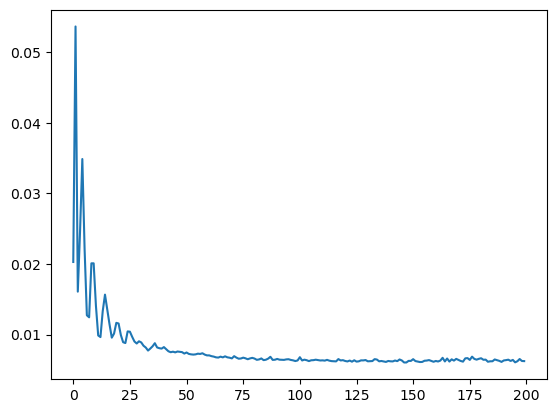

In [16]:
from matplotlib import pyplot as plt
plt.plot(hists['bulk3'])

In [17]:
### pipeline
if __name__ == "__main__":
    for seqp in range(40,len(sids),BATCH_SIZE):
        ### load this rounds representatives and cluster labels
        if seqp <= BATCH_SIZE:
            rnd = 1
            print('start initial round')
            reprefile = 'training_rec/init_representatives_'+str(BATCH_SIZE)+'.txt' 
            clusterfile = 'training_rec/init_cluster_labels_'+str(BATCH_SIZE)+'.txt' 

            f = open(reprefile,'r')
            lines=f.readlines()
            representatives=[]
            for l in lines:
                representatives.append(int(l.strip().split()[0]))
            f.close()

            f= open(clusterfile,'r')
            cluster_labels=[]
            lines=f.readlines()
            for l in lines:
                cluster_labels.append(int(l.strip().split()[0]))
            f.close()
            
        else:
            rnd = int(seqp/4)
            print('start round '+str(rnd))
            reprefile = 'training_rec/eer_representatives_'+str(rnd)+'.txt' 
            clusterfile = 'training_rec/eer_cluster_labels_'+str(rnd)+'.txt' 

            f= open(reprefile,'r')
            lines=f.readlines()
            representatives=[]
            for l in lines:
                representatives.append(int(l.strip().split()[0]))
            f.close()

            f= open(clusterfile,'r')
            cluster_labels=[]
            lines=f.readlines()
            for l in lines:
                cluster_labels.append(int(l.strip().split()[0]))
            f.close()
        ### end of loading representatives and cluster labels



        ### reconstruction stage 1
        c=0
        #procs=[]
        for rp in representatives:#new_representatives:
            pid = pids[rp]
            if ('fast_reconst1_'+pid) in os.listdir('covid_models'):
                print('recon' + str(pid) + 'exist')
                continue
            device = 'cuda:' + str(c%8)
            fastrecon(pid=pid,tgtpid=None,device=device,k=15,diagw=1,vaesteps=100,gansteps=100,save=True,path=None)
            
            #proc = Process(target=multirecon, args=(rp,device))
            #procs.append(proc)
            #proc.start()
            c=c+1
        
        #for proc in procs:
        #        proc.join()
        ### end of recon stage 1

        ### reconstruction stage 2
        i=0
        c=0
        procs=[]
        for rp in representatives:##new_representatives:
            pid = pids[rp]
            device = 'cuda:' + str(c%8)
            if ('fastreconst2_'+pid) in os.listdir('covid_models'):
                print('recon2' + str(pid) + 'exist')
                continue
            adata,adj,variances,bulk,geneset_len = setdata(pid,None,device=device,k=15,diagw=1.0)
            reconmodel = fastgenerator(adj = adj,variances = variances,markermask = None,bulk=bulk,geneset_len = geneset_len,adata=adata,\
                        n_hidden=256,n_latent=32,dropout_rate=0,countbulkweight=0,logbulkweight=0,absbulkweight=0,abslogbulkweight=0,\
                        power=2,corrbulkweight=0,meanbias=0)
            reconmodel.module.load_state_dict(torch.load('covid_models/fast_reconst1_'+str(pid)))
            reconst_pretrain2(pid,reconmodel,device,k=15,diagw=1.0,vaesteps=50,gansteps=50,save=True)
            
            
            #proc = Process(target=multirecon2, args=(rp,reconmodel,device))
            #procs.append(proc)
            #proc.start()
            #c=c+1
            #i+=1
        #for proc in procs:
        #        proc.join()
        ### end of recon stage 2


        
        


        
        ### semi profiling
        procs = []
        c=0

        l0 = []
        l1 = []
        l2 = []
        l3 = []
        l4 = []
        l5 = []
        l6 = []
        l7 = []

        for i in range(0,30):
            if i in representatives:
                continue
            reprepid = pids[representatives[cluster_labels[i]]]
            if ('fast'+ reprepid+'_to_'+str(pids[i])+'.npy') not in os.listdir('semidata'):
                l0.append(i)
            else:
                print('exist')
        for i in range(30,60):
            if i in representatives:
                continue
            reprepid = pids[representatives[cluster_labels[i]]]
            if ('fast'+ reprepid+'_to_'+str(pids[i])+'.npy') not in os.listdir('semidata'):
                l1.append(i)
            else:
                print('exist')
        for i in range(60,90):
            if i in representatives:
                continue
            reprepid = pids[representatives[cluster_labels[i]]]
            if ('fast'+ reprepid+'_to_'+str(pids[i])+'.npy') not in os.listdir('semidata'):
                l2.append(i)
            else:
                print('exist')
        for i in range(90,len(sids)):
            if i in representatives:
                continue
            reprepid = pids[representatives[cluster_labels[i]]]
            if ('fast'+ reprepid+'_to_'+str(pids[i])+'.npy') not in os.listdir('semidata'):
                l3.append(i)
            else:
                print('exist')
                
        '''
        for i in range(56,70):
            if i in representatives:
                continue
            reprepid = pids[representatives[cluster_labels[i]]]
            if ('fast'+ reprepid+'_to_'+str(pids[i])+'.npy') not in os.listdir('semidata'):
                l4.append(i)
            else:
                print('exist')
        for i in range(70,84):
            if i in representatives:
                continue
            reprepid = pids[representatives[cluster_labels[i]]]
            if ('fast'+ reprepid+'_to_'+str(pids[i])+'.npy') not in os.listdir('semidata'):
                l5.append(i)
            else:
                print('exist')
        for i in range(84,98):
            if i in representatives:
                continue
            reprepid = pids[representatives[cluster_labels[i]]]
            if ('fast'+ reprepid+'_to_'+str(pids[i])+'.npy') not in os.listdir('semidata'):
                l6.append(i)
            else:
                print('exist')
        for i in range(98,112):
            if i in representatives:
                continue
            reprepid = pids[representatives[cluster_labels[i]]]
            if ('fast'+ reprepid+'_to_'+str(pids[i])+'.npy') not in os.listdir('semidata'):
                l7.append(i)
            else:
                print('exist')'''
        
        
        
        
        
        proc = Process(target=multisemi, args=(l0,'cuda:0',rnd))
        procs.append(proc)
        proc.start()
        proc = Process(target=multisemi, args=(l1,'cuda:1',rnd))
        procs.append(proc)
        proc.start()
        proc = Process(target=multisemi, args=(l2,'cuda:2',rnd))
        procs.append(proc)
        proc.start()
        proc = Process(target=multisemi, args=(l3,'cuda:3',rnd))
        procs.append(proc)
        proc.start()
    
        '''
        proc = Process(target=multisemi, args=(l4,'cuda:4',rnd))
        procs.append(proc)
        proc.start()
        proc = Process(target=multisemi, args=(l5,'cuda:5',rnd))
        procs.append(proc)
        proc.start()
        proc = Process(target=multisemi, args=(l6,'cuda:6',rnd))
        procs.append(proc)
        proc.start()
        proc = Process(target=multisemi, args=(l7,'cuda:7',rnd))
        procs.append(proc)
        proc.start()'''
        
        
        
        
        
            
        for proc in procs:
            proc.join()
        ### end semi 


        ### load new semi results
        t_start = timeit.default_timer()
        semis=[]
        for i in range(len(pids)):
            pid = pids[i]
            repre = representatives[cluster_labels[i]]
            reprepid = pids[repre]
            if reprepid==pid:
                semis.append(gts[i])
            else:
                xsem = np.load('semidata/fast'+ reprepid+'_to_'+pid+'.npy')
                xsem = xsem*(xsem>10)                                   ############### thresholding
                semis.append(xsem)
            print(i,end=', ')

        t_end = timeit.default_timer()
        print()
        print(str(t_end-t_start),'for loading semi')
        ### end of loading semi

        from sklearn.decomposition import TruncatedSVD

        ### PCA
        t_start = timeit.default_timer()
        
        X = np.concatenate([np.concatenate(gts,axis=0),np.concatenate(semis,axis=0)],axis=0)
        X = np.log(X+1)
        reducer =  PCA(n_components = 100)#PCA(n_components = 100)#,svd_solver = 'randomized')#randomized_svd(n_components=100)  #PCA(n_components=100)#
        X_reduced = reducer.fit_transform(X)

        t_end = timeit.default_timer()
        print()
        print(str(t_end-t_start),'for pca')
        ### end of pca


        ### reduced data for patients
        xdimgts=[]
        xdimsemis=[]
        offset=0
        xused = X_reduced#X_UMAP # X_PCA
        for i in range(len(pids)):
            xdimgts.append(xused[offset:(offset+gts[i].shape[0]),:])
            offset = offset+gts[i].shape[0]
        lengt = offset
        for i in range(len(pids)):
            xdimsemis.append(xused[offset:(offset+semis[i].shape[0]),:])
            offset = offset+semis[i].shape[0]
        ### end 

        
        ### lowerbound
        lbscores2 = []
        
        
        
        
        lbgt = copy.deepcopy(X_reduced)
        np.random.shuffle(lbgt)
        lbgt1 = lbgt[:lbgt.shape[0]//2,:]
        lbgt2 = lbgt[lbgt.shape[0]//2:,:]
        
        #lbgt1 = copy.deepcopy(X_reduced)
        #lbgt2 = copy.deepcopy(X_reduced)
        ma = np.array(lbgt1).copy(order='C')
        mb = np.array(lbgt2).copy(order='C')
        lowerbound = list(faiss_knn(ma,mb,n_neighbors=1)) + list(faiss_knn(mb,ma,n_neighbors=1))
        lowerbound = np.array(lowerbound)
        lowerbound = lowerbound.mean()

        #lowerbound = 40
        
        ### upperbound
        ubscores = []
        for i in range(len(pids)):
            gt = xdimgts[i]
            randomidx = np.random.randint(0,len(pids))
            gtr = xdimgts[randomidx]
            ma = np.array(gt).copy(order='C')
            mb = np.array(gtr).copy(order='C')
            ubscore = list(faiss_knn(ma,mb,n_neighbors=1)) + list(faiss_knn(mb,ma,n_neighbors=1))
            ubscores.append(np.array(ubscore).mean())
        upperbound = np.array(ubscores).mean()
        
        
        
        ### semi evaluation
        t_start = timeit.default_timer()
        scores = []
        for i in range(len(pids)):
            pid = pids[i]
            if i in representatives:
                scores.append(lowerbound)
                continue
            gt = xdimgts[i]
            xs = xdimsemis[i]
            ma = np.array(gt).copy(order='C')
            mb = np.array(xs).copy(order='C')
            err1 = faiss_knn(ma,mb,n_neighbors=1)
            err2 = faiss_knn(mb,ma,n_neighbors=1)
            err = list(err1) + list(err2)
            err = (np.array(err)).mean()
            scores.append(err)
        semierror = np.array(scores).mean()

        ### naive evaluation
        naivescores = []
        for i in range(len(pids)):
            pid = pids[i]
            if i in representatives:
                naivescores.append(lowerbound)
                continue
            gt = xdimgts[i]
            repre = representatives[cluster_labels[i]]
            xs = xdimgts[repre]
            ma = np.array(gt).copy(order='C')
            mb = np.array(xs).copy(order='C')
            err1 = faiss_knn(ma,mb,n_neighbors=1)
            err2 = faiss_knn(mb,ma,n_neighbors=1)
            err = list(err1) + list(err2)
            err = (np.array(err)).mean()
            naivescores.append(err)
        naiveerror = np.array(naivescores).mean()


        normednaive = (naiveerror - lowerbound)/(upperbound - lowerbound)
        normedsemi = (semierror - lowerbound)/(upperbound - lowerbound)
        t_end = timeit.default_timer()
        print('naive:',naiveerror)
        print('semi:',semierror)
        print('upperbound:',upperbound)
        print('lowerbound;',lowerbound)
        print('normed naive:',normednaive)
        print('normed semi:',normedsemi)
        print(str(t_end-t_start),' for evaluation')
        
        f=open('performance/semi_pca_t10_'+str(rnd)+'.txt','w')
        f.write('naive:'+str(naiveerror)+'\n')
        f.write('semi:'+str(semierror)+'\n')
        f.write('upperbound:'+str(upperbound)+'\n')
        f.write('lowerbound;'+str(lowerbound)+'\n')
        f.write('normed naive:'+str(normednaive)+'\n')
        f.write('normed semi:'+str(normedsemi)+'\n')
        f.close()
        ### end of evaluation


        ### active learning 
        nrep, nlabels = pick_batch_eee(reduced_bulk=reduced_bulk,\
                        representatives=representatives,\
                        cluster_labels=cluster_labels,\
                        xdimsemis=xdimsemis,\
                        xdimgts=xdimgts,\
                        discount_rate = 1,\
                        semi_dis_rate = 1,\
                        batch_size=4\
                       )
        new_representatives = nrep
        new_cluster_labels = nlabels
        f=open('training_rec/eer_cluster_labels_'+str(rnd+1)+'.txt','w')
        for i in range(len(new_cluster_labels)):
            f.write(str(new_cluster_labels[i])+'\n')
        f.close()
        f=open('training_rec/eer_representatives_'+str(rnd+1)+'.txt','w')
        for i in range(len(new_representatives)):
            f.write(str(new_representatives[i])+'\n')
        f.close()

        cluster_labels = new_cluster_labels
        representatives = new_representatives


start round 10
reconMH9143276exist
reconBGCV09_CV0279exist
reconMH8919282exist
reconMH9143426exist
reconBGCV06_CV0178exist
reconAP8exist
reconnewcastle59exist
reconMH8919333exist
reconBGCV12_CV0926exist
reconMH9143273exist
reconMH9143324exist
reconMH8919226exist
reconBGCV10_CV0198exist
reconMH9143325exist
reconBGCV13_CV0934exist
reconAP6exist
reconBGCV08_CV0073exist
reconnewcastle20exist
reconMH8919279exist
reconMH9143275exist
reconBGCV03_CV0176exist
reconMH9143322exist
reconMH9179827exist
reconMH9143270exist
reconMH8919331exist
reconMH9143373exist
reconAP1exist
reconMH8919329exist
reconMH9143424exist
reconBGCV14_CV0284exist
reconMH8919332exist
reconMH9179822exist
reconBGCV04_CV0164exist
reconBGCV01_CV0025exist
reconBGCV05_CV0284exist
reconMH8919330exist
reconBGCV10_CV0231exist
reconMH9143427exist
reconBGCV07_CV0104exist
reconAP11exist
recon2MH9143276exist
recon2BGCV09_CV0279exist
recon2MH8919282exist
recon2MH9143426exist
recon2BGCV06_CV0178exist
recon2AP8exist
recon2newcastle59exist
r

In [ ]:
err1

In [ ]:
!nvidia-smi

In [ ]:
1+1